In [23]:
import pandas as pd
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data

In [24]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()

In [25]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

## Preparing bigram statistical model

In [26]:
import torch
# torch.set_default_device("mps")
bigramModel = torch.zeros(27,27)
uniques = set(x for x in "".join(word for word in names+["."]))
uniques = dict([(x,i) for i,x in enumerate(sorted(uniques))])
rev_uniques = dict([value,keys] for keys,value in uniques.items())

bigrams = {}
for word in names:
    word = "." + word + "."
    for ch1,ch2 in zip(word,word[1:]):
        bigrams[ch1,ch2] = bigrams.get((ch1,ch2),0) + 1

In [27]:
bigrams = dict(sorted(bigrams.items(),key= lambda x:x[1],reverse=True))

In [28]:
[x for x in bigrams.items()][:5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

In [29]:
for x in bigrams.keys():
    bigramModel[uniques[x[0]],uniques[x[1]]] = bigrams[x]

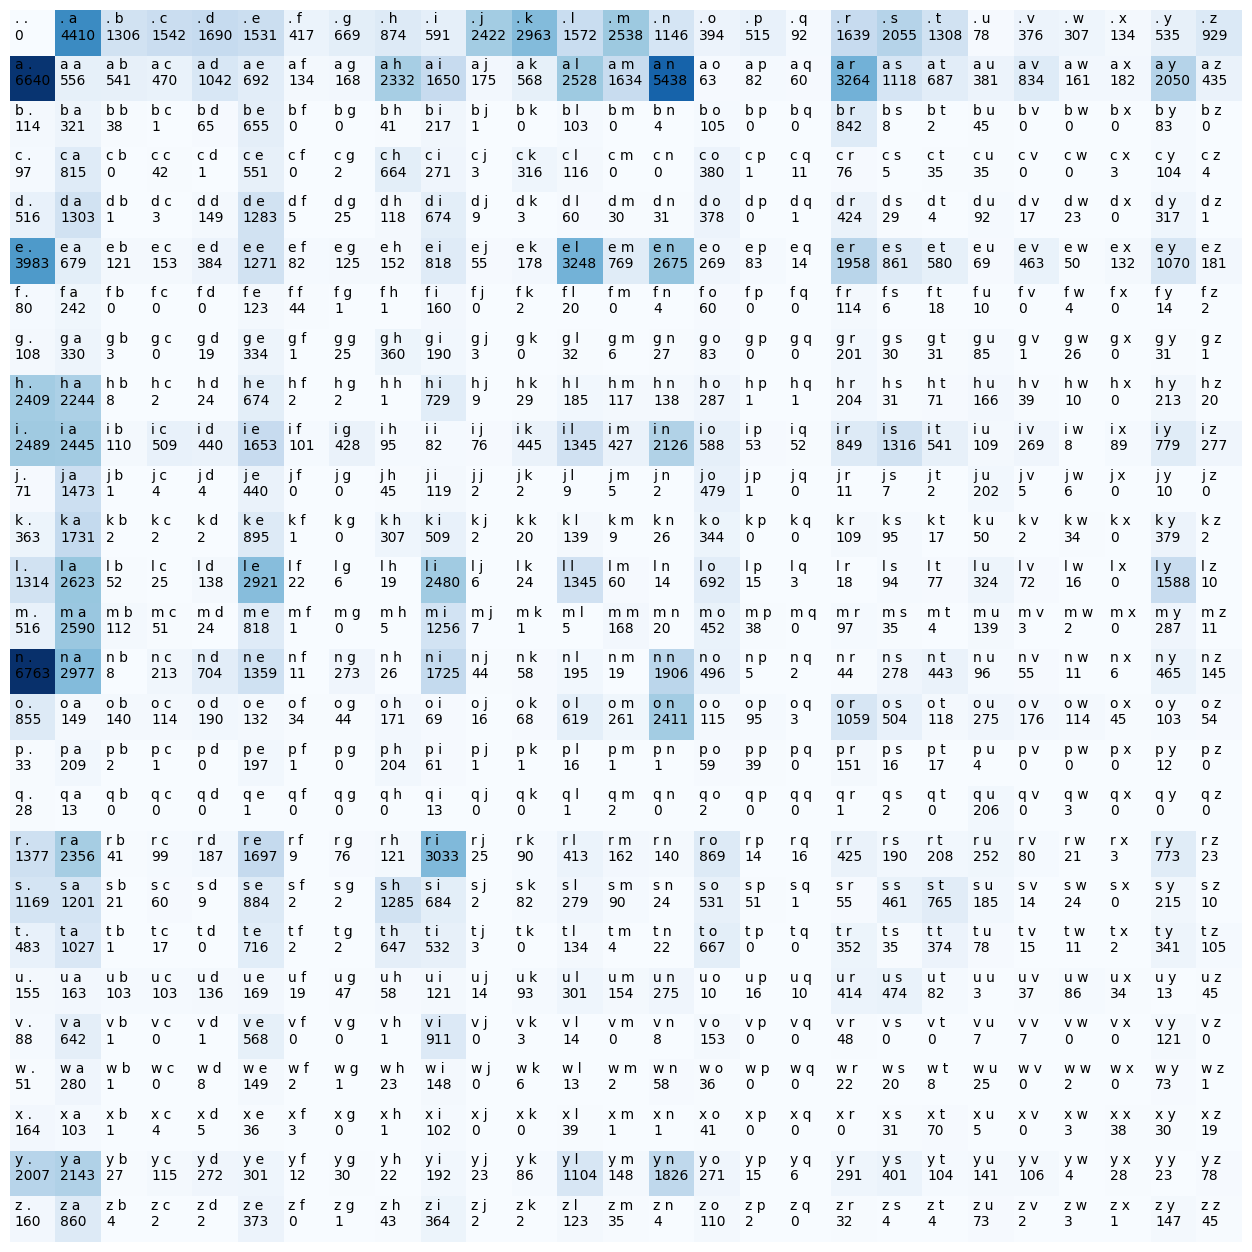

In [30]:
fig,axes = plt.subplots()
fig.set_figheight(16)
fig.set_figwidth(16)
axes.imshow(bigramModel,cmap="Blues")
axes.set_xticks(list(uniques.values()),list(uniques.keys()))
axes.tick_params(axis="x",top = True,bottom=False,labeltop = True,labelbottom = False)
axes.set_axis_off()
for x in range(bigramModel.shape[0]):
    for y in range(bigramModel.shape[1]):
        axes.annotate(f"{rev_uniques[y]} {rev_uniques[x]}\n{bigramModel[y,x].item():.0f}",(x-.4,y+.15))
axes.set_yticks(list(uniques.values()),list(uniques.keys()))
plt.show()

In [31]:
P=bigramModel+5
bigramModel_norm = P/P.sum(1,keepdim = True)

In [32]:
bigramModel_norm[0].sum()

tensor(1.)

In [33]:

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = bigramModel_norm[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(rev_uniques[ix])
    if ix == 0:
      break
  print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


### Calculating loss

In [34]:
log_likelihood = 0.0
n = 0

for w in names:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = uniques[ch1]
    ix2 = uniques[ch2]
    prob = bigramModel_norm[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-560645.1875)
nll=tensor(560645.1875)
2.4573965072631836


## NN method

In [35]:
xs,ys = [],[]
# torch.set_default_device("mps")
for word in names:
    word = "." + word + "."
    # print(word)
    for ch1,ch2 in zip(word,word[1:]):
        # print(ch1,ch2)
        xs.append(uniques[ch1])
        ys.append(uniques[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [36]:
# torch.set_default_device("mps")
print(xs.shape,ys.shape)
ohx = torch.nn.functional.one_hot(xs,num_classes  = 27).float()
# ohy = torch.nn.functional.one_hot(xs,num_classes = 27)

torch.Size([228146]) torch.Size([228146])


In [37]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [38]:
g = torch.Generator().manual_seed(2147483647)
W =torch.randn((27,27),requires_grad =True)


In [40]:
for x in range(1000):
    #forward pass
    logits = ohx @ W
    # exp = logits.exp()
    # pred = exp/exp.sum(1,keepdims=True)
    # ypred = pred.argmax(1,keepdim =True)
    loss =  torch.nn.functional.cross_entropy(logits,ys) ##-pred[torch.arange(xs.nelement()),ys].log().mean()
    # print(loss)
    #backpass
    W.grad = None
    loss.backward()
    
    #update gradients
    W.data += -10*W.grad
print(loss.item())

2.4579200744628906


In [41]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    ix = 0
    out = []
    while True:
        oix = torch.nn.functional.one_hot(torch.tensor([ix]),num_classes = 27).float()
        logits1=oix @ W
        exp1 = logits1.exp()
        p = exp1/exp1.sum(1,keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
          break
        out.append(rev_uniques[ix])

    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka


## Trigram Model

In [207]:
triuniques ={(y,x):i+j+26*j for j,y in enumerate(uniques.keys()) for i,x in enumerate(uniques.keys())}
rev_triuniques = { i: key for key,i in triuniques.items() }
trigramModel =  torch.zeros(len(triuniques),27)
tridict = {}
for x in names:
    a = "."+x+"."
    for ch1,ch2,ch3 in zip(a,a[1:],a[2:]):
        trigramModel[triuniques[ch1,ch2],uniques[ch3]] += 1

In [210]:
triP = trigramModel + 1
triP = triP/triP.sum(1,keepdim=True)

In [226]:

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ch1 = "."
  ch2 = "."
  while True:
    p=triP[triuniques[ch1,ch2]]
    ix= torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(rev_uniques[ix])
    ch1 = ch2
    ch2 = rev_uniques[ix]
    if ix == 0:
      break
  print(''.join(out))

ce.
za.
zogh.
uriana.
kaydnevonimittain.


In [227]:
log_likelihood = 0.0
n = 0

for w in names:
  a = ['.'] + list(w) + ['.']
for ch1,ch2,ch3 in zip(a,a[1:],a[2:]):
    ix1 = triuniques[ch1,ch2]
    ix2 = uniques[ch3]
    prob = triP[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-19.4326)
nll=tensor(19.4326)
3.8865227699279785


In [225]:
triP[triuniques[".","."]]

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

In [192]:
for x in names:
    a = "."+x+"."
    for ch1,ch2,ch3 in zip(a,a[1:],a[2:]):
        tridict[ch1,ch2,ch3] = tridict.get((ch1,ch2,ch3),0) + 1

In [220]:
triP[0,0]

tensor(0.0370)

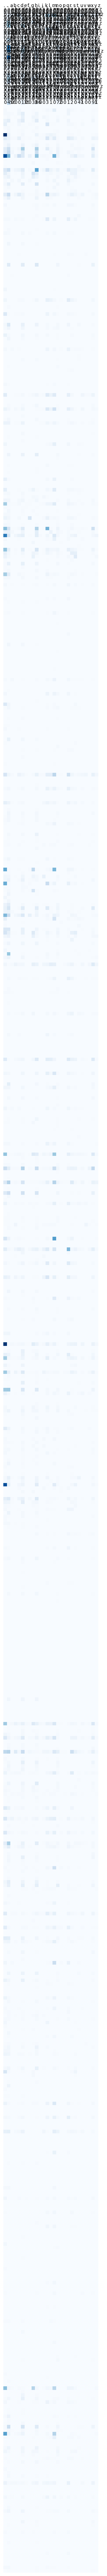

In [232]:
fig,axes = plt.subplots()
fig.set_figheight(100)
fig.set_figwidth(500)
axes.imshow(trigramModel,cmap="Blues")
axes.set_xticks(list(uniques.values()),list(uniques.keys()))
axes.tick_params(axis="x",top = True,bottom=False,labeltop = True,labelbottom = False)
axes.set_axis_off()
for x in range(bigramModel.shape[0]):
    for y in range(bigramModel.shape[1]):
        axes.annotate(f"{rev_uniques[y]} {rev_uniques[x]}\n{trigramModel[y,x].item():.0f}",(x-.4,y+.15))
axes.set_yticks(list(uniques.values()),list(uniques.keys()))
plt.show()